In [1]:
#RUN USING ANACONDA

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchvision
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
from scipy import stats
import time


In [2]:
base_path = Path.cwd().resolve()
print(base_path)

C:\Users\Matth\OneDrive\Desktop\Singlelayer_NN_Model


In [3]:
data_dir = "2020_LaserNetCSUCombinedData"
os.chdir(f'{base_path}\\{data_dir}\\SCRAM\\Code')
from import_scram import SCRAM
from simulate_scram import SCRAMTarget
os.chdir(base_path)

In [4]:
#Define energy axes, density layers, and temp layers


def plotterx(dens, temp, flor, err,dx=0.5e-4, dens2=3, temp2=3, flor2=0.003, err2=0, dx2 = 0.5e-4, ploton=False, compare = False):
    en_VH = np.linspace(8,9.97,2995) #Spectral range of front side von Hamos spectrometer
    en_HR = np.linspace(8,8.45,2995) #Spectral range of rear side spherical crystal spectrometer
    dens = [dens] #Solid Density copper LOW BoUND: 2.23; HIGH BOUND 18.00
    temp = [temp] #Reasonable temperature of 3.5 keV #LOW BOUND 0.10; HIGH BOUND 6.40
    dens2 = [dens2]
    temp2 = [temp2]
     #Single layer of thickness 500 nm

    #get interpolators for j,k, and fluorescence
    scram = SCRAM(f'{data_dir}/SCRAM/SCRAM.txt')
    j,k,j_f,k_f,fh,fj = scram.get_scram_intrp(dx) #Extracts j, k from SCRAM

    target1 = SCRAMTarget(dens,temp,j,k,j_f,k_f,fh,fj,en_VH,en_HR,dx) #Generates class object with the specified parameters
    target2 = SCRAMTarget(dens2,temp2,j,k,j_f,k_f,fh,fj,en_VH,en_HR,dx2)
    #generating test spectra with noise
    #target = SCRAMTarget(dens,temp,j,k,en_VH,en_HR,dx)
    test_VH, test_HR = target1.model(dens,temp,flor,100)
    test_VH2, test_HR2 = target2.model(dens2,temp2,flor2,100)

    
    error = err #controls how noisy the spectra are
    error2 = err2
    noise_VH = np.random.normal(0,error*np.std(test_VH),en_VH.shape)
    
    
    noise_VH2 = np.random.normal(0,error2*np.std(test_VH2),en_VH.shape)
    noise_HR2 = np.random.normal(0,error2*np.std(test_HR2),en_HR.shape)
    
    if ploton == True:
        fig, axs = plt.subplots(nrows = 2, ncols = 1)
        fig.set_figwidth(10)
        fig.set_figheight(8)
        fig.tight_layout(pad = 4)
        fig.suptitle('Simulated Spectra with Gaussian Noise')

        axs[0].plot(en_VH,test_VH+noise_VH, label = 'Simulated')
        axs[0].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
        axs[0].set(xlabel = 'Photon Energy [keV]')
        
        axs[1].plot(en_HR,test_HR+noise_VH)
        axs[1].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
        axs[1].set(xlabel = 'Photon Energy [keV]');
        
        if compare == True:
            axs[0].plot(en_VH,test_VH2+noise_VH2, label = 'Predicted', linestyle = '--')
            axs[0].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
            axs[0].set(xlabel = 'Photon Energy [keV]')
            axs[0].legend()

            axs[1].plot(en_HR,test_HR2+noise_HR2, linestyle = '--')
            axs[1].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
            axs[1].set(xlabel = 'Photon Energy [keV]');
            axs[1].legend()
        colors = np.random.rand(3,3)
        axs[0].axvspan(8.01,8.07,alpha=0.3,color=(0.1,0.9,0.1),label =r'$K \alpha$')
        axs[0].axvspan(8.17,8.31,alpha=0.3,color=(.1,0.70,0.400),label =r'$Li-Like$')
        axs[0].axvspan(8.31,8.42,alpha=0.3,color=(0.1,0.60,0.6),label =r'$He \alpha$')
        axs[0].axvspan(8.62,8.72,alpha=0.3,color=(0.3,0.5,0.7),label =r'$Ly \alpha$')
        axs[0].axvspan(8.87,8.92,alpha=0.3,color=(0.4,0.4,0.8),label =r'$K \beta$')
        axs[0].axvspan(9.72,9.9,alpha=0.3,color=(0.7,0.7,0.9),label =r'$He \beta$')
        axs[0].legend()

        axs[1].axvspan(8.01,8.07,alpha=0.3,color=(0.1,0.9,0.1),label =r'$K \alpha$')
        axs[1].axvspan(8.17,8.31,alpha=0.3,color=(.1,0.70,0.400),label =r'$Li-Like$')
        axs[1].axvspan(8.31,8.42,alpha=0.3,color=(0.1,0.60,0.6),label =r'$He \alpha$')
        axs[1].legend()
    intensityVH = []
    intensityHR = []
    intensityVH.append(test_VH+noise_VH)
    intensityHR.append(test_HR+noise_VH)
    energy_intensity_dfVH = pd.concat([pd.DataFrame(en_VH.reshape(1,-1)),pd.DataFrame(intensityVH)])
    energy_intensity_dfHR = pd.concat([pd.DataFrame(en_VH.reshape(1,-1)),pd.DataFrame(intensityHR)])
    return energy_intensity_dfHR, energy_intensity_dfVH

In [5]:
#Define energy axes, density layers, and temp layers


def plotter(dens, temp, flor, err,dx=0.5e-4, dens2=3, temp2=3, flor2=0.003, err2=0, dx2 = 0.5e-4, ploton=False, compare = False):
    en_VH = np.linspace(8,9.97,2995) #Spectral range of front side von Hamos spectrometer
    en_HR = np.linspace(8,8.45,2995) #Spectral range of rear side spherical crystal spectrometer
    dens = [dens] #Solid Density copper LOW BoUND: 2.23; HIGH BOUND 18.00
    temp = [temp] #Reasonable temperature of 3.5 keV #LOW BOUND 0.10; HIGH BOUND 6.40
    dens2 = [dens2]
    temp2 = [temp2]
     #Single layer of thickness 500 nm

    #get interpolators for j,k, and fluorescence
    scram = SCRAM(f'{data_dir}/SCRAM/SCRAM.txt')
    j,k,j_f,k_f,fh,fj = scram.get_scram_intrp(dx) #Extracts j, k from SCRAM

    target1 = SCRAMTarget(dens,temp,j,k,j_f,k_f,fh,fj,en_VH,en_HR,dx) #Generates class object with the specified parameters
    target2 = SCRAMTarget(dens2,temp2,j,k,j_f,k_f,fh,fj,en_VH,en_HR,dx2)
    #generating test spectra with noise
    #target = SCRAMTarget(dens,temp,j,k,en_VH,en_HR,dx)
    test_VH, test_HR = target1.model(dens,temp,flor,100)
    test_VH2, test_HR2 = target2.model(dens2,temp2,flor2,100)
    
    
    error = err #controls how noisy the spectra are
    error2 = err2
    noise_VH = np.random.normal(0,error*np.std(test_VH),en_VH.shape)
    noise_HR = np.random.normal(0,error*np.std(test_HR),en_HR.shape)
    
    noise_VH2 = np.random.normal(0,error2*np.std(test_VH2),en_VH.shape)
    noise_HR2 = np.random.normal(0,error2*np.std(test_HR2),en_HR.shape)
    
    if ploton == True:
        fig, axs = plt.subplots(nrows = 2, ncols = 1)
        fig.set_figwidth(10)
        fig.set_figheight(8)
        fig.tight_layout(pad = 4)
        fig.suptitle('Simulated Spectra with Gaussian Noise')

        axs[0].plot(en_VH,test_VH+noise_VH, label = 'Simulated')
        axs[0].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
        axs[0].set(xlabel = 'Photon Energy [keV]')
        
        axs[1].plot(en_HR,test_HR+noise_HR)
        axs[1].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
        axs[1].set(xlabel = 'Photon Energy [keV]');
        
        if compare == True:
            axs[0].plot(en_VH,test_VH2+noise_VH2, label = 'Predicted', linestyle = '--')
            axs[0].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
            axs[0].set(xlabel = 'Photon Energy [keV]')
            axs[0].legend()

            axs[1].plot(en_HR,test_HR2+noise_HR2, linestyle = '--')
            axs[1].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
            axs[1].set(xlabel = 'Photon Energy [keV]');
            axs[1].legend()
        colors = np.random.rand(3,3)
        axs[0].axvspan(8.01,8.07,alpha=0.3,color=(0.1,0.9,0.1),label =r'$K \alpha$')
        axs[0].axvspan(8.17,8.31,alpha=0.3,color=(.1,0.70,0.400),label =r'$Li-Like$')
        axs[0].axvspan(8.31,8.42,alpha=0.3,color=(0.1,0.60,0.6),label =r'$He \alpha$')
        axs[0].axvspan(8.62,8.72,alpha=0.3,color=(0.3,0.5,0.7),label =r'$Ly \alpha$')
        axs[0].axvspan(8.87,8.92,alpha=0.3,color=(0.4,0.4,0.8),label =r'$K \beta$')
        axs[0].axvspan(9.72,9.9,alpha=0.3,color=(0.7,0.7,0.9),label =r'$He \beta$')
        axs[0].legend()

        axs[1].axvspan(8.01,8.07,alpha=0.3,color=(0.1,0.9,0.1),label =r'$K \alpha$')
        axs[1].axvspan(8.17,8.31,alpha=0.3,color=(.1,0.70,0.400),label =r'$Li-Like$')
        axs[1].axvspan(8.31,8.42,alpha=0.3,color=(0.1,0.60,0.6),label =r'$He \alpha$')
        axs[1].legend()
    intensity = []
    intensity.append(test_VH+noise_VH)

    energy_intensity_df = pd.concat([pd.DataFrame(en_VH.reshape(1,-1)),pd.DataFrame(intensity)])
    return energy_intensity_df

In [8]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        #self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        #self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        #self.dropout2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)

        #self.bn3 = nn.BatchNorm1d(hidden_size3)
        self.dropout3 = nn.Dropout(p=0.1)
        self.fc4 = nn.Linear(hidden_size3, output_size)

    def forward(self, x):
        out = self.fc1(x)
        #out = self.bn1(out)
        out = self.relu(out)
        out = self.fc2(out)
        #out = self.bn2(out)
        out = self.leaky_relu(out)
        #out = self.dropout2(out)
        out = self.fc3(out)
        #out = self.bn3(out)
        out = self.relu(out)
        out = self.fc4(out)
        return out


class classifyingNN(nn.Module):
    def __init__(self):
        super(classifyingNN, self).__init__()
        self.fc1 = nn.Linear(5, 10)
        self.fc2 = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


model100640 = FeedforwardNN(8,128,256,128,2)
model10100 = FeedforwardNN(21,128,256,128,3)

classifier = classifyingNN()

model100640.load_state_dict(torch.load(f'{base_path}\\models\\highNN.pth'))
model10100.load_state_dict(torch.load(f'{base_path}\\models\\lowNN.pth'))
classifier.load_state_dict(torch.load(f'{base_path}\\models\\classifier.pth'))
classipca = joblib.load(f'{base_path}\\classifier\\pca.pkl')


In [12]:
DensityScaler_high = joblib.load(f'{base_path}\\processedhigh\\DensityScaler.pkl')
TempScaler_high = joblib.load(f'{base_path}\\processedhigh\\TempScaler.pkl')
ROIPCA_high = joblib.load(f'{base_path}\\processedhigh\\EIDPCA.pkl')



DensityScaler_low = joblib.load(f'{base_path}\\processedlow\\DensityScaler.pkl')
TempScaler_low = joblib.load(f'{base_path}\\processedlow\\TempScaler.pkl')
HEFScaler_low = joblib.load(f'{base_path}\\processedlow\\HEFScaler.pkl')
ROIPCA_low = joblib.load(f'{base_path}\\processedlow\\EIDPCA.pkl')




In [39]:
rand_dens = np.random.uniform(2.23,6)
rand_temp = np.random.uniform(0.1,2)
rand_flor = np.random.uniform(1e-4,1e-2)
rand_err = np.random.uniform(0.0,0.2)
print(f'dens = {rand_dens}, temp = {rand_temp}, flor = {rand_flor}, noise = {rand_err}')


_, energy_intensity_dfVH  = plotterx(rand_dens,rand_temp,rand_flor, rand_err)
energy_intensity_dfVH = energy_intensity_dfVH.iloc[1,:]
energy_intensity_npVH = energy_intensity_dfVH.to_numpy()
energy_intensity_npVH = energy_intensity_npVH.reshape(1, -1)

dens = 3.519726762915601, temp = 0.11225993071776943, flor = 0.0009359284232703703, noise = 0.05048984015719502
5e-05


In [36]:
def snv(data):
    mean = np.mean(data, axis=1, keepdims=True)
    std_dev = np.std(data, axis=1, keepdims=True)
    return (data - mean) / std_dev

def recursivemodel(model, energy_intensity_npVH, pcas, densscaler, tempscaler,HEFscaler,switch):
    slicer = pcas.transform(snv(energy_intensity_npVH))
    SNVslice = np.concatenate([slicer[0],[np.array(min(energy_intensity_npVH[0]))],[np.array(max(energy_intensity_npVH[0][0:250]))],[np.array(max(energy_intensity_npVH[0][250:750]))],[np.array(max(energy_intensity_npVH[0][750:1100]))],[np.array(max(energy_intensity_npVH[0][2500:2995]))]]) 
    
    test_tensor = torch.tensor(SNVslice, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        outputs = model(test_tensor)
        vals = outputs.detach().numpy()
        predicted_labels = pd.DataFrame(vals.reshape(1,-1))
        predicted_labels.iloc[:, 0] = densscaler.inverse_transform(predicted_labels.iloc[:, 0].values.reshape(-1, 1)).flatten()
        predicted_labels.iloc[:, 1] = tempscaler.inverse_transform(predicted_labels.iloc[:, 1].values.reshape(-1, 1)).flatten()
        if switch == False:
            predicted_labels.iloc[:, 2] = HEFscaler.inverse_transform(predicted_labels.iloc[:, 2].values.reshape(-1, 1)).flatten()
            predicted_labels[2] = np.power(10, predicted_labels[2])
        vals = predicted_labels.to_numpy()[0]
        if switch == True:
            vals = np.append(vals,1e-3)
        
    return vals

    
def modelensemble(energy_intensity_npVH): 
    outputs_ = True
    classy = classipca.transform(snv(energy_intensity_npVH))
    outputs_ = classifier(torch.tensor(classy, dtype=torch.float32)).detach().numpy().flatten()[0]>0.5
    
    if outputs_ == True:
        print('High temp')
        vals = recursivemodel(model100640,energy_intensity_npVH, ROIPCA_high,DensityScaler_high,TempScaler_high,1,outputs_)
        #vals = recursivemodel(model10100_2,low_scalers,energy_intensity_npVH, low_PCA, DensityScaler_low,TempScaler_low,HEFScaler_low,False)
    if outputs_ == False:
        print('Low temp')
        vals = recursivemodel(model10100,energy_intensity_npVH, ROIPCA_low, DensityScaler_low,TempScaler_low,HEFScaler_low,outputs_)
    return vals
   
    
    
    

In [37]:
outputs = modelensemble(energy_intensity_npVH)
print(outputs)


Low temp
[9.0371304e+00 8.6408831e-02 9.4703917e-04]


In [72]:
rand_dens = np.random.uniform(2.23,18)
rand_temp = np.random.uniform(0.1,6.4)
rand_flor = np.random.uniform(1e-4,1e-2)
rand_err = np.random.uniform(0.0,0.2)
print(f'dens = {rand_dens}, temp = {rand_temp}, flor = {rand_flor}, noise = {rand_err}')


_, energy_intensity_dfVH  = plotterx(rand_dens,rand_temp,rand_flor, rand_err)
energy_intensity_dfVH = energy_intensity_dfVH.iloc[1,:]
energy_intensity_npVH = energy_intensity_dfVH.to_numpy()
energy_intensity_npVH = energy_intensity_npVH.reshape(1, -1)

dens = 2.5554186005919934, temp = 5.346839145103679, flor = 0.008167679799409149, noise = 0.15798796638682086
5e-05


In [73]:
outputs = modelensemble(energy_intensity_npVH)
print(outputs)


High temp
[2.51068640e+00 5.33554029e+00 1.00000000e-03]


5e-05


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


9.496229094333495


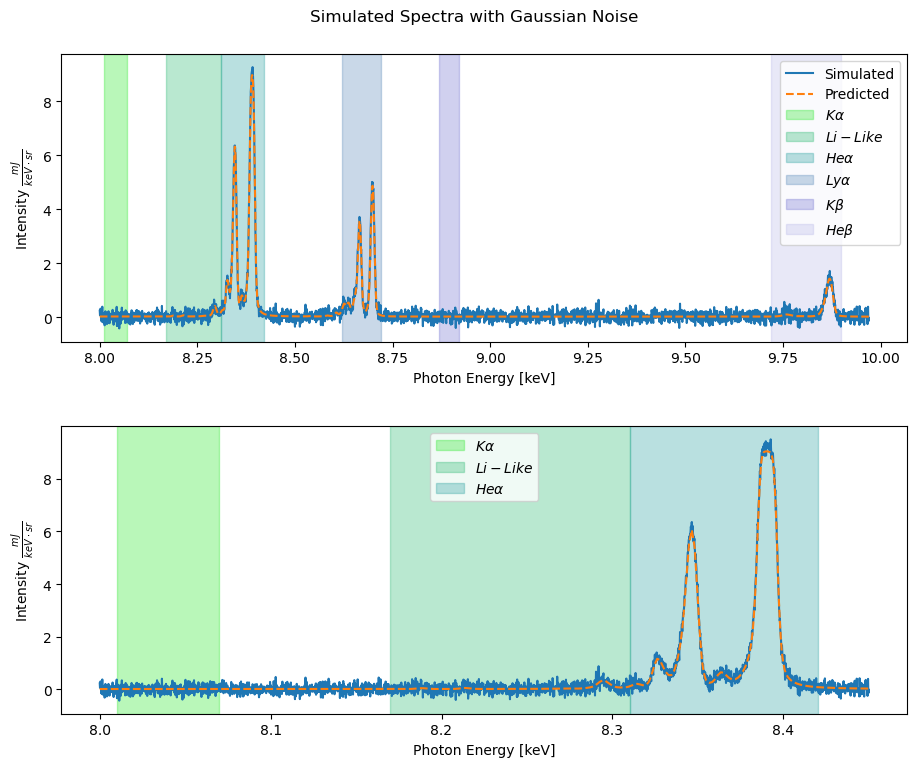

In [74]:
x,_ = plotterx(rand_dens,rand_temp,rand_flor, rand_err,dens2=outputs[0],temp2=outputs[1],flor2=outputs[2],ploton=True,compare = True)
#plotter(12,2,0.01, 0, dens2 =12 ,temp2 = 1.01,flor2 =0.01,err2 = 0,ploton=True,compare = True)
print(max(x.iloc[1,:]))

In [58]:
#Define energy axes, density layers, and temp layers
num_trials = 100
num_concats = 100
scram = SCRAM(f'{data_dir}/SCRAM/SCRAM.txt')
dx = 0.5e-4 #Single layer of thickness 500 nm
# get interpolators for j,k, and fluorescence
j,k,j_f,k_f,fh,fj = scram.get_scram_intrp(dx) #Extracts j, k from SCRAM
en_VH = np.linspace(8,9.97,2995) #Spectral range of front side von Hamos spectrometer
en_HR = np.linspace(8,8.45,2995) #Spectral range of rear side spherical crystal spectrometer

energy_intensity_df2 = pd.DataFrame()
dens_temp_noise_df2 = pd.DataFrame()
for n in range(num_concats):
    intensity = []
    variables = []
    for i in range(num_trials):

        dens = [np.random.uniform(2.24,10.764)] #Solid Density copper LOW BoUND: 2.23; HIGH BOUND 18.00
        temp = [np.random.uniform(0.1,6.4)] #Reasonable temperature of 3.5 keV #LOW BOUND 0.10; HIGH BOUND 6.40
        if temp[0] >=1:
            flor = 25
        else:
            flor = np.random.uniform(1e-4, 1e-2)
        target = SCRAMTarget(dens,temp,j,k,j_f,k_f,fh,fj,en_VH,en_HR,dx) #Generates class object with the specified parameters
        #generating test spectra with noise
        test_VH, test_HR = target.model(dens,temp,flor,100)
        error = np.random.uniform(0,0.2) #controls how noisy the spectra are
        noise_VH = np.random.normal(0,error*np.std(test_VH),en_VH.shape)
        noise_HR = np.random.normal(0,error*np.std(test_HR),en_HR.shape)
        
        intensity.append(test_VH+noise_VH)
        variables.append([dens[0], temp[0],flor])

    energy_intensity_df = pd.DataFrame(intensity)
    dens_temp_noise_df = pd.DataFrame(variables)
    energy_intensity_df2= pd.concat([energy_intensity_df2,energy_intensity_df],ignore_index=True)
    dens_temp_noise_df2= pd.concat([dens_temp_noise_df2,dens_temp_noise_df],ignore_index=True)
    print(n)


5e-05
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [59]:
joblib.dump(energy_intensity_df2, f'{base_path}\\testdatasets\\EID.pkl')
joblib.dump(dens_temp_noise_df, f'{base_path}\\testdatasets\\DTD.pkl')

['C:\\Users\\Matth\\OneDrive\\Desktop\\Singlelayer_NN_Model\\testdatasets\\DTD.pkl']

In [60]:
energy_intensity_df2 = joblib.load(f'{base_path}\\testdatasets\\EID.pkl')
dens_temp_noise_df= joblib.load(f'{base_path}\\testdatasets\\DTD.pkl')

In [61]:
a_real, a_guess, b_real, b_guess, c_real, c_guess  = [], [], [], [], [], []
for i in range(0,num_trials*num_concats):
    
    xydfslice = energy_intensity_df2.iloc[i,:]
    xydfslice = xydfslice.to_numpy()
    xydfslice = xydfslice.reshape(1, -1)
    outputs = modelensemble(xydfslice)
    
    a_real.append(dens_temp_noise_df2.iloc[i,:].to_numpy().flatten()[0])
    a_guess.append(outputs[0])
    b_real.append(dens_temp_noise_df2.iloc[i,:].to_numpy().flatten()[1])
    b_guess.append(outputs[1])
    c_real.append(dens_temp_noise_df2.iloc[i,:].to_numpy().flatten()[2])
    c_guess.append(outputs[2])    

remove_temp = [index for index, value in enumerate(c_real) if value == 25]

c_real = [value for index, value in enumerate(c_real) if index not in remove_temp]
c_guess = [value for index, value in enumerate(c_guess) if index not in remove_temp]



High temp
High temp
High temp
High temp
High temp
Low temp
High temp
Low temp
High temp
Low temp
High temp
High temp
High temp
Low temp
High temp
High temp
Low temp
Low temp
High temp
High temp
High temp
High temp
Low temp
High temp
High temp
High temp
High temp
High temp
High temp
High temp
High temp
High temp
High temp
High temp
High temp
Low temp
Low temp
High temp
High temp
High temp
High temp
High temp
High temp
Low temp
High temp
High temp
High temp
High temp
High temp
High temp
High temp
High temp
High temp
High temp
Low temp
High temp
High temp
High temp
High temp
Low temp
High temp
High temp
High temp
High temp
High temp
High temp
Low temp
High temp
High temp
High temp
High temp
High temp
High temp
High temp
High temp
Low temp
High temp
High temp
High temp
High temp
High temp
High temp
Low temp
High temp
High temp
High temp
High temp
High temp
High temp
High temp
Low temp
High temp
High temp
High temp
High temp
High temp
High temp
High temp
High temp
High temp
High temp
High t

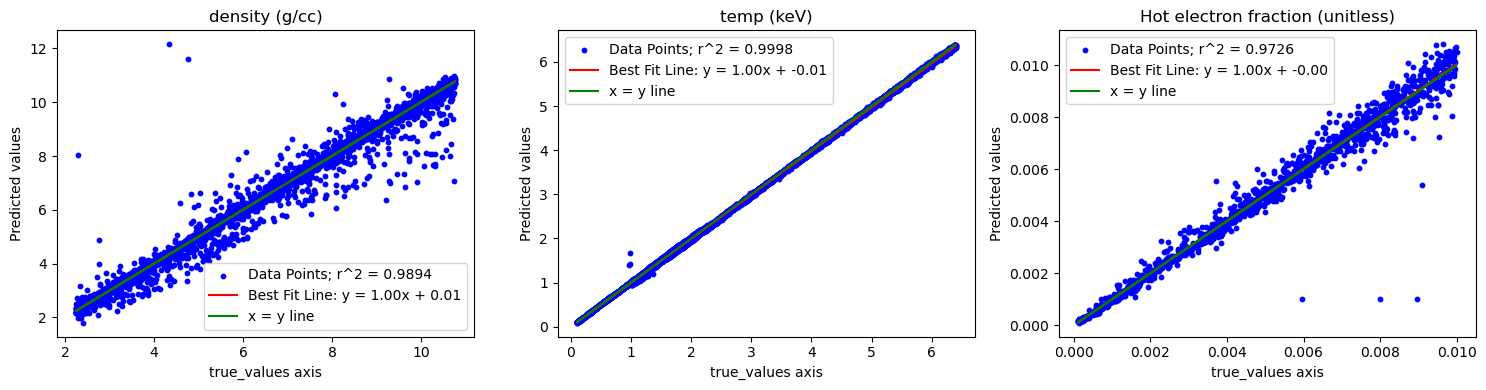

In [62]:
def plotabc(real, guess, name,ax):
    slope, intercept, r, p, std_err = stats.linregress(real, guess)
    r2 = r**2
    
    line = slope * np.array(real) + intercept
    ax.scatter(real, guess, color='blue', label=f'Data Points; r^2 = {r2:0.4f}', s=10)
    ax.plot(real, line, color='red', label=f'Best Fit Line: y = {slope:.2f}x + {intercept:.2f}')
    ax.plot(real, real, color='green', label=f'x = y line')
    ax.set_xlabel('true_values axis')
    ax.set_ylabel('Predicted values')
    ax.set_title(f'{name}')
    ax.legend()
    # print(slope)
    # print(intercept)
    


_, axs = plt.subplots(1, 3, figsize=(15, 4))
plotabc(a_real, a_guess, 'density (g/cc)',axs[0])
plotabc(b_real, b_guess, 'temp (keV)',axs[1])
plotabc(c_real, c_guess, 'Hot electron fraction (unitless)',axs[2])
plt.tight_layout()

1.7579718475386432
1.0696433615116916
6.021813100002444


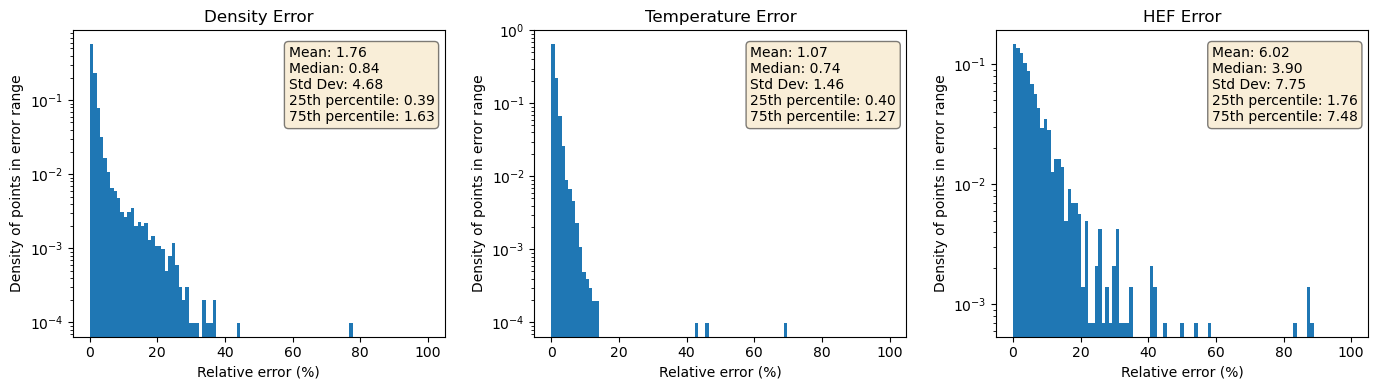

0.9709


In [63]:
def coefficient_error(guess, real):
    error = abs((np.array(guess)-np.array(real))/np.array(real)*100)
    return error


a_error = (coefficient_error(a_guess, a_real)).tolist()
b_error = (coefficient_error(b_guess, b_real)).tolist()
c_error = (coefficient_error(c_guess, c_real)).tolist()

def plot_hist(errors, title, ax):
    bins = np.linspace(0, 100, 100)
    ax.hist(errors, bins=bins, log=True,density = True )
    ax.set_title(title)
    ax.set_xlabel('Relative error (%)')
    ax.set_ylabel('Density of points in error range')
    
    mean = np.mean(errors)
    print(mean)
    median = np.median(errors)
    mode_result = stats.mode(errors)
    modex = mode_result.mode if mode_result.count.size > 0 else "No mode"
    std_dev = np.std(errors)
    percentile_25 = np.percentile(errors, 25)
    percentile_75 = np.percentile(errors, 75)
    
    textstr = '\n'.join((
        f'Mean: {mean:.2f}',
        f'Median: {median:.2f}',
        #f'Mode: {modex:.2f}' if modex != "No mode" else f'Mode: {modex}',
        f'Std Dev: {std_dev:.2f}',
        f'25th percentile: {percentile_25:.2f}',
        f'75th percentile: {percentile_75:.2f}'
    ))
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.58, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

_, axs = plt.subplots(1, 3, figsize=(14, 4))

plot_hist(a_error, 'Density Error', axs[0])
plot_hist(b_error, 'Temperature Error', axs[1])
plot_hist(c_error, 'HEF Error', axs[2])
plt.tight_layout()
plt.show()

count = len([x for x in a_error if x < 10])/len(a_error)
print(count)